In [2]:
import csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Settings
PATH = '.' # if running locally
# PATH = '/home/lmacy1/predictiveml' # if running on ARCC
data_path = f'{PATH}/clean_data_extended'
buildings_list = ['Stadium_Data_Extended.csv']
save_model_file = False
save_model_plot = True
min_number_of_days = 365
memory_limit = 102400
exclude_column = 'present_co2_tons'

y_columns = ['present_elec_kwh', 'present_htwt_mmbtu', 'present_wtr_usgal', 'present_chll_tonhr', 'present_co2_tons']
add_features = ['temp_c', 'rel_humidity_%', 'surface_pressure_hpa', 'cloud_cover_%', 'direct_radiation_w/m2', 'precipitation_mm', 'wind_speed_ground_km/h', 'wind_dir_ground_deg']

# Training scope
models = {}
model_types = ['ensembles', 'solos']
preprocessing_methods = ['arima']
feature_modes = ['rfe', 'lasso']

# Hyperparameters
n_features_list = list(range(1, len(add_features)))
n_folds = 5
time_steps = [1, 8, 12, 24]
minutes_per_model = 2
split_rate = 0.8

for model_type in model_types:
    out_path = f'{PATH}/models/{model_type}/'

    for building in buildings_list:
        df = pd.read_csv(f'{data_path}/{building}')

        # Convert the data into a Pandas dataframe
        df['ts'] = pd.to_datetime(df['ts'])
        df = df.drop_duplicates(subset=['bldgname', 'ts'])
        df = df.sort_values(['bldgname', 'ts'])

        # Group the dataframe by building name and timestamp
        groups = df.groupby('bldgname')
        df = df.set_index('ts')
        header = ['ts'] + y_columns + add_features

        print(building)

        # cycle through building names if more than one building per file
        for name, group in groups:
            bldgname = name
            group = group.drop_duplicates(subset=['ts'])

            # cycle through commodities
            for y in y_columns:

                col_data = group[header]

                # check if column contains the min number of days and is a valid commodity to train on
                if col_data[y].count() >= min_number_of_days * 24 and y != exclude_column:

                    # cycle through preprocessing methods
                    for preprocessing_method in preprocessing_methods:

                        model_data = col_data.copy()
                        model_data = model_data.rename(columns={ y: 'y', 'ts': 'ds' })
                        model_data = model_data.sort_values(['ds'])

                        # save the original values into new column
                        model_data['y_saved'] = model_data['y']

                        # Fill in missing values (Preprocessing)
                        
                        # *** ARIMA (daily seasonality, m=24) (5/5) ***

                        # m = auto_arima(model_data[model_data['y'].notna()]['y'].values, seasonal=True, m=24*365, suppress_warnings=False)

                        # y_pred, conf_int = m.predict(n_periods=model_data['y'].isna().sum())
                        # model_data.loc[model_data['y'].isna(), 'y'] = y_pred


                        break
                    break
                break
            break
        break
    break

                        

Stadium_Data_Extended.csv


In [4]:
df = model_data.copy()
model_data['y_saved'] = model_data['y']

In [5]:
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds')
# df= df.sort_index()
df = df.asfreq('H')
# df = dfa['y'].dropna()
df.head()

,y,present_htwt_mmbtu,present_wtr_usgal,present_chll_tonhr,present_co2_tons,temp_c,rel_humidity_%,surface_pressure_hpa,cloud_cover_%,direct_radiation_w/m2,precipitation_mm,wind_speed_ground_km/h,wind_dir_ground_deg,y_saved
ds,,,,,,,,,,,,,,
2019-09-19 00:00:00,NaN,NaN,NaN,NaN,NaN,12.2,53.0,779.9,0.0,0.0,0.0,15.6,165.0,NaN
2019-09-19 01:00:00,NaN,NaN,NaN,NaN,NaN,11.6,54.0,779.3,0.0,0.0,0.0,13.4,172.0,NaN
2019-09-19 02:00:00,NaN,NaN,NaN,NaN,NaN,10.9,57.0,778.2,0.0,0.0,0.0,11.2,178.0,NaN
2019-09-19 03:00:00,NaN,NaN,NaN,NaN,NaN,10.3,60.0,777.3,0.0,0.0,0.0,9.1,189.0,NaN
2019-09-19 04:00:00,NaN,NaN,NaN,NaN,NaN,9.7,62.0,776.8,0.0,0.0,0.0,8.0,185.0,NaN


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Total Consumption')]

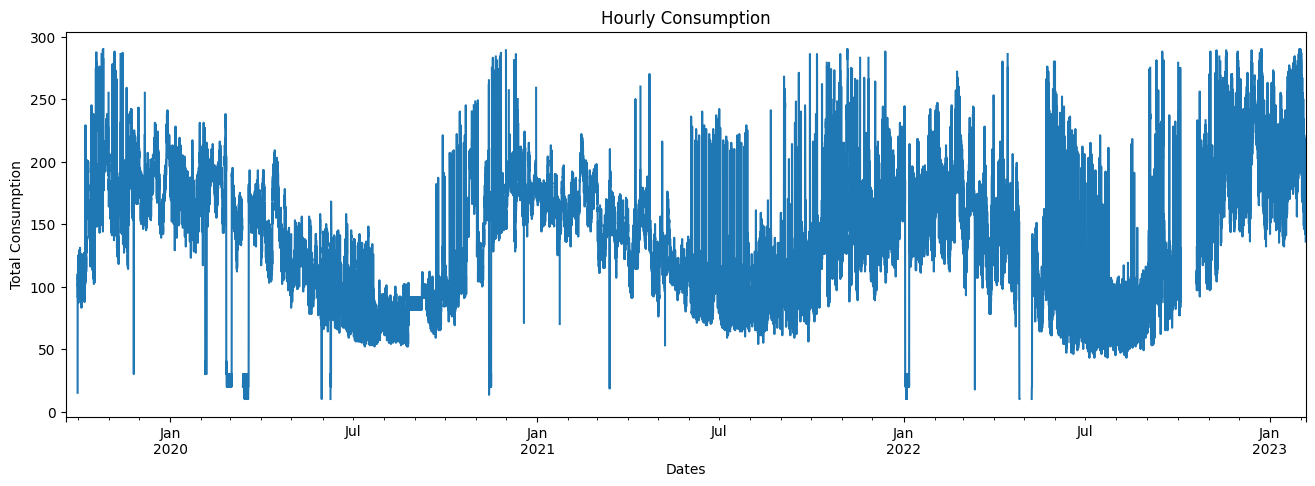

In [6]:
#Basic Data Plot
df.index.freq = 'H'
ax = df['y'].plot(figsize = (16,5), title = "Hourly Consumption")
ax.set(xlabel='Dates', ylabel='Total Consumption')

In [7]:
#Seasonal Decompose Plots
# df = df.dropna(subset=['y'])
# df['y'] = df['y'].interpolate(method='linear', limit_direction='both')  
# df['y'] = df['y'].fillna(method='bfill')

# a = seasonal_decompose(df['y'], model = "add")

# a.plot()

In [8]:
# import matplotlib.pyplot as plt
# plt.figure(figsize = (16,7))
# a.seasonal.plot();

In [ ]:
#ARIMA Forecast
#Finding the best values for p,q,d,P,Q,D

m = auto_arima(model_data[model_data['y'].notna()]['y'].values, seasonal=False, m=24, suppress_warnings=False)
m.summary()

<Axes: >

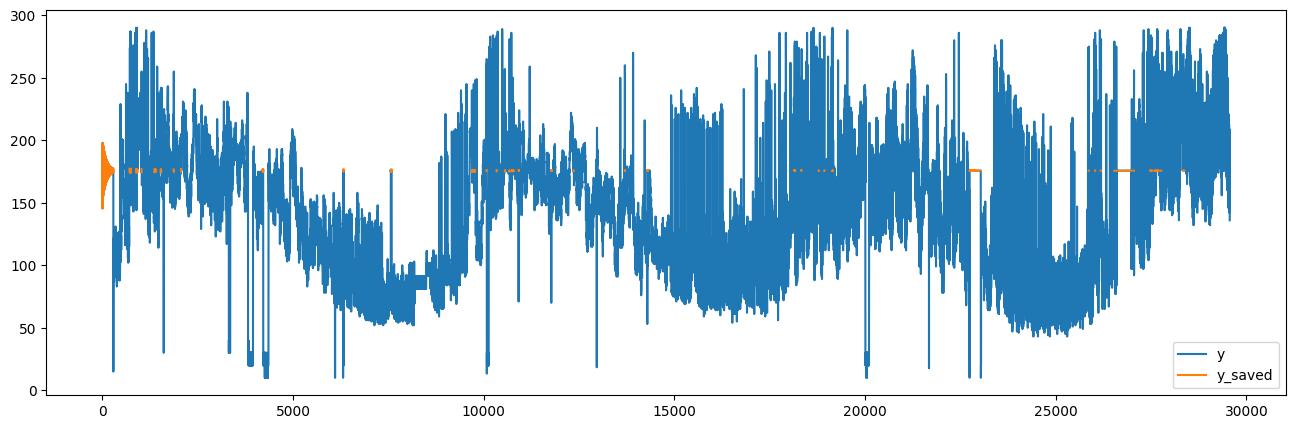

In [10]:
n_periods = int(model_data['y'].isna().sum())
y_pred = m.predict(n_periods=n_periods)
model_data.loc[model_data['y'].isna(), 'y'] = y_pred


nan_mask = np.isnan(model_data['y_saved'])  # boolean mask of NaN values in saved_y
model_data.loc[model_data['y_saved'].isna(), 'y_saved'] = y_pred
model_data['y_saved'][~nan_mask] = np.nan

model_data['y'].plot(figsize=(16, 5), legend=True)
model_data['y_saved'].plot(legend=True)


In [ ]:
#Train-Test split
split_rate = 0.99
train_size = int(len(model_data['y']) * split_rate)
test_size = len(model_data['y']) - train_size 
train_data = model_data['y'][0:train_size]
test_data = model_data['y'][train_size:len(model_data['y'])]

arima_model = auto_arima(train_data, seasonal=False, m=24, suppress_warnings=False)
arima_model.summary()

# arima_model = SARIMAX(train_data, order = (5, 1, 5))
# arima_result = arima_model.fit()
# arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                29269
Model:               SARIMAX(5, 1, 5)   Log Likelihood             -128607.556
Date:                Fri, 19 May 2023   AIC                         257237.113
Time:                        11:56:59   BIC                         257328.239
Sample:                             0   HQIC                        257266.386
                              - 29269                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4413      0.021    -20.561      0.000      -0.483      -0.399
ar.L2         -0.0586      0.010     -5.949      0.000      -0.078      -0.039
ar.L3         -0.6749      0.008    -85.225      0.000      -0.690      -0.659
ar.L4          0.3054      0.014     22.260      0.000       0.279       0.332
ar.L5          0.3666      0.009     38.892      0.000       0.348       0.385
ma.L1         -0.0613      0.022     -2.800      0.005      -0.104      -0.018
ma.L2         -0.0809      0.008    -10.357      0.000      -0.096      -0.066
ma.L3          0.4246      0.006     66.735      0.000       0.412       0.437
ma.L4         -0.7223      0.008    -84.984      0.000      -0.739      -0.706
ma.L5         -0.2773      0.016    -17.083      0.000      -0.309      -0.245
sigma2       380.4992      1.288    295.489      0.000     377.975     383.023
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            163310.80
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

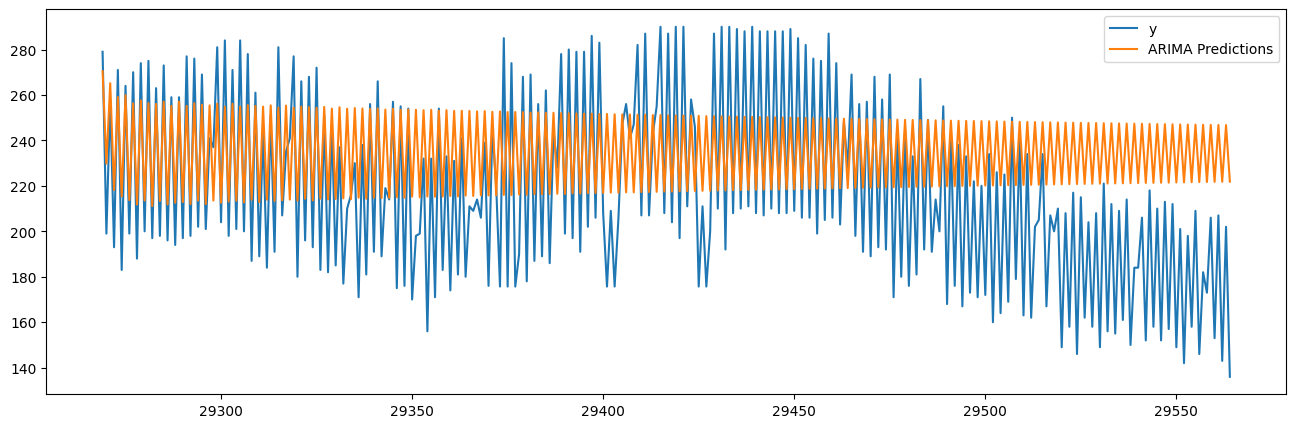

In [ ]:
# Prediction
start_idx = len(train_data)  # Start index for prediction
end_idx = len(model_data['y'])  # End index for prediction

arima_pred = arima_model.predict(n_periods=(end_idx - start_idx)).rename("ARIMA Predictions")

# Plot the test_data and arima_pred
test_data.plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True)

In [ ]:
#Model Evaluation
arima_rmse_error = rmse(test_data.values, arima_pred.values)
arima_mse_error = arima_rmse_error**2
mean_value = model_data['y'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 1227.3971386612623
RMSE Error: 35.03422810140481
Mean: 139.97063486172962
